## Hypothesis Testing with the Northwind Traders Database and SQL

Let's start by importing the necessary libraries for this project.

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Next, we'll use SQLAlchemy to create an engine.  This will be our gateway to accessing the database and querying data via SQL select statements.  We'll also use the inspector object to see what table names are contained in the database.

In [2]:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
print(inspector.get_table_names())

2019-03-26 20:56:37,996 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-26 20:56:37,998 INFO sqlalchemy.engine.base.Engine ()
2019-03-26 20:56:38,002 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-26 20:56:38,004 INFO sqlalchemy.engine.base.Engine ()
2019-03-26 20:56:38,007 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-03-26 20:56:38,009 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


We are successfully connected.  The output using inspector is not very user-friendly, so we'll use the function below to explore the individual tables going forward.

In [3]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

## Objective:
### - Using the Northwind database, answer 4 questions using hypothesis testing to generate analytical insight that can be used by the company.  The first question is provided below.
### Q1: **_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**
### The company's ERD (Entity Relationship Diagram) is also provided:
<img src='Northwind_ERD.png'>

## My basic thought process at the outset:

### Some broader questions presented themselves first, centered around the key business components of the company:
- Products <br>
   -- What do we sell?
- Suppliers    
    -- Who are our suppliers?  
    -- Where are they located?  
    -- Why do we buy from them?
- Customers <br>
    -- Who are our customers?  
    -- Where are they located?  
    -- What do we sell most successfully to them?
- Workforce <br>
    -- Who are our employees?  
    -- Where are they located?  
    -- Which are the most successful and why?
    


# Database EDA

- While I won't delve into all the exploratory analysis conducted, the code below is an example of the process I used, for each table within the database, to better acquaint myself with the data points we can access.  I usually started by selecting all columns from a particular table and previewing it.  After viewing the complete table, questions more limited in scope generally followed (with several more specific SQL queries for each table).

In [4]:
get_columns_info('Product')

2019-03-26 20:56:38,043 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-03-26 20:56:38,048 INFO sqlalchemy.engine.base.Engine ()
Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


In [5]:
prod_df = pd.read_sql_query("SELECT * FROM Product", engine)
prod_df.head()

2019-03-26 20:56:38,077 INFO sqlalchemy.engine.base.Engine SELECT * FROM Product
2019-03-26 20:56:38,079 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


>Example: *I see that Chef Anton's Gumbo Mix is "Discontinued".*  This led me to ask:
>- How many of our products are discontinued? 
>- What categories are they in? 
>- What commonalities do they share?  
>- What are their respective price points?

In [6]:
discontinued = '''SELECT ProductName, SupplierId, CategoryId, UnitPrice FROM Product
                    WHERE Discontinued = 1
                    ORDER BY UnitPrice DESC'''
pd.read_sql_query(discontinued, engine)

2019-03-26 20:56:38,162 INFO sqlalchemy.engine.base.Engine SELECT ProductName, SupplierId, CategoryId, UnitPrice FROM Product
                    WHERE Discontinued = 1
                    ORDER BY UnitPrice DESC
2019-03-26 20:56:38,165 INFO sqlalchemy.engine.base.Engine ()


,ProductName,SupplierId,CategoryId,UnitPrice
0,Thüringer Rostbratwurst,12,6,123.79
1,Mishi Kobe Niku,4,6,97.00
2,Rössle Sauerkraut,12,7,45.60
3,Alice Mutton,7,6,39.00
4,Perth Pasties,24,6,32.80
5,Chef Anton's Gumbo Mix,2,2,21.35
6,Singaporean Hokkien Fried Mee,20,5,14.00
7,Guaraná Fantástica,10,1,4.50


At first glance, we see that 4 of the 8 products share the same CategoryId (6, which we found corresponds to "Meat/Poultry" after later joining the Category table).

Perhaps we can gain some insight just by going down the rabbit hole of "Discontinued product analysis", or it might just be a dead end...but either way it will give us a better understanding of the database and may lead to more useful questions about our current product line/product mix.

For what it's worth, I considered analyzing the popularity of meat/poultry products vs. vegetarian products after I discovered the rather alarming trend of discontinuations above, but ultimately decided against it.  File that under "future work."

On to the first question:

# Q1a: Do discounts have a statistically significant effect on the number of products customers order? 

We can find everything we need to answer this in the OrderDetail table.

In [7]:
q1 = "SELECT Quantity, Discount FROM OrderDetail"
q1_df = pd.read_sql_query(q1, engine)
q1_df.head()

2019-03-26 20:56:38,190 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM OrderDetail
2019-03-26 20:56:38,192 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [8]:
q1_df.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


Let's make this binary for the first part of the question - we're only interested in whether a discount was given, not the level of discount.

In [9]:
q1_df['Discounted'] = q1_df['Discount'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
no_disc = q1_df[q1_df['Discounted'] == 0]
disc = q1_df[q1_df['Discounted'] == 1]

Let's visualize the distributions as well as the means now that we have subsets for both.

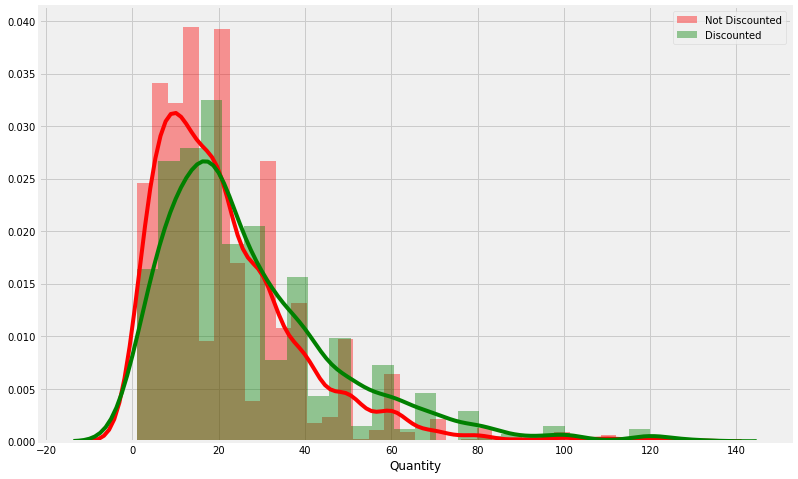

In [11]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12,8))
sns.distplot(no_disc['Quantity'], color= 'r', label = 'Not Discounted')
sns.distplot(disc['Quantity'], color = 'g', label = 'Discounted')
plt.legend()
plt.show();

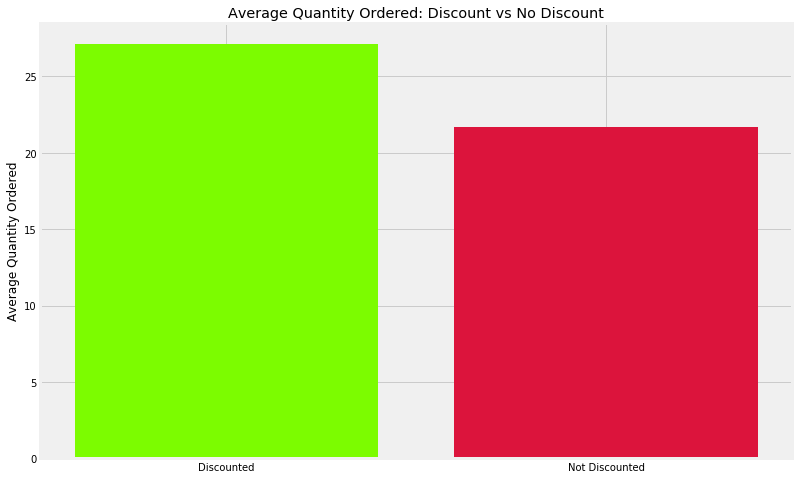

In [12]:
colormap = ('lawngreen', 'crimson')
X = ['Discounted', 'Not Discounted']
y = [disc.Quantity.mean(), no_disc.Quantity.mean()]
plt.figure(figsize=(12,8))
plt.bar(X, y, color=colormap)
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered: Discount vs No Discount')
plt.show();

From the visualizations, it's clear that the discounted orders appear to come in higher quantities.  Let's proceed to hypothesis testing to determine if there is *a statistically significant difference.*

First, we'll state our null and alternative hypotheses and declare a significance level $\alpha$.

**H<sub>0</sub>: There is no difference in the quantity of products that customers order when given a discount** <br>
**H<sub>A</sub>: The quantity of products that customers order INCREASES when given a discount** <br>
**$\alpha$: 0.05**

To determine the answer, we'll use a two-sample t-test.

In [13]:
t, p = stats.ttest_ind(no_disc['Quantity'], disc['Quantity'])
print('T-statistic: {}, Two-tailed p-value: {}'.format(t,p))# this is 2-tailed by default
print('One tailed p-value: {}'.format(p/2))  #to give us our 1-tailed p-value

T-statistic: -6.4785631962949015, Two-tailed p-value: 1.1440924523215966e-10
One tailed p-value: 5.720462261607983e-11


## Q1a results:
Our p-value is microscopic and far below the alpha level of 0.05, so ***we can reject the null hypothesis and conclude that there is a statistically significant increase in quantity of products ordered when customers are given a discount.***

# Q1b: If so (i.e. if Q1a is statistically signifcant), at what level(s) of discount?

For this part of the question, we are interested in the specific levels of discount, so we'll return to our original dataframe.

In [14]:
q1_df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [15]:
q1_df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Let's focus on 5%, 10%, 15%, 20%, 25%...the others are small discount levels and have extremely small samples, so it's clear that the company rarely offers discounts that aren't at some multiple of 5% anyways.

In [16]:
q1_df.shape

(2155, 3)

In [17]:
q1b_df = q1_df[q1_df['Discount'].isin([0.05, 0.10, 0.15, 0.20, 0.25])]

In [18]:
q1b_df.shape

(830, 3)

Just a sanity check....looks like we successfully filtered out the non-discounted items and those other occasional discounts of 1%, 2%, 3%, 4%, and 6%.

In [19]:
discount_count = q1b_df['Discount'].value_counts()

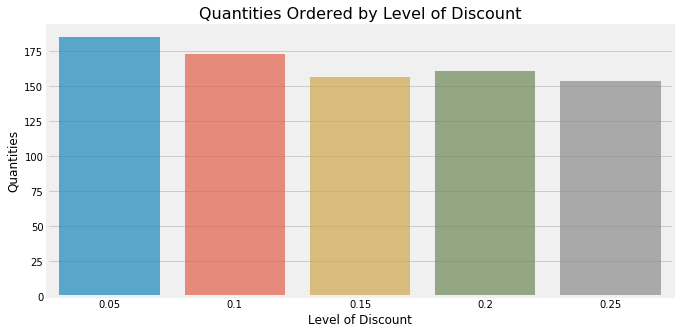

In [20]:
plt.figure(figsize=(10,5))
plt.title("Quantities Ordered by Level of Discount", fontsize =16)
sns.barplot(discount_count.index, discount_count.values, alpha = 0.7)
plt.ylabel('Quantities', fontsize=12)
plt.xlabel('Level of Discount', fontsize=12)
plt.show();

Let's again declare our hypotheses and significance level before testing:

**H<sub>0</sub>: The average quantity ordered is the same across all levels of discount** <br>
**H<sub>A</sub>: The average quantity ordered differs depending on discount level** <br>
**$\alpha$: 0.05**

Let's first use ANOVA testing since we have more than 2 samples and we want to generally determine if there's a statistically significant difference between any of them.

In [21]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, q1b_df).fit()
table = sm.stats.anova_lm(lm, typ=1) #1 way anova because we only have 1 ind var (quantity)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),4.0,1159.517551,289.879388,0.674103,0.610041
Residual,825.0,354768.342690,430.022234,NaN,NaN


## Q1b results:

OK, our p-value is quite high here compared to our alpha level, 0.61 > 0.05.  Based on the ANOVA results, we ***fail to reject the null hypothesis and conclude that there is not a statistically significant difference in the quantity ordered based on the discount level offered.*** <br>

However, I am curious to see how each discount level compares to the other, so for further analysis we'll use a Tukey HSD test below.

In [22]:
mc = MultiComparison(q1b_df['Quantity'], q1b_df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.05   0.1   -2.7738  -8.7696 3.222  False 
 0.05   0.15   0.3714  -5.7803 6.523  False 
 0.05   0.2    -0.986  -7.0962 5.1242 False 
 0.05   0.25   0.2294  -5.9546 6.4134 False 
 0.1    0.15   3.1452  -3.1037 9.394  False 
 0.1    0.2    1.7879  -4.4202 7.9959 False 
 0.1    0.25   3.0033  -3.2774 9.2839 False 
 0.15   0.2   -1.3573   -7.716 5.0014 False 
 0.15   0.25  -0.1419  -6.5715 6.2877 False 
 0.2    0.25   1.2154  -5.1745 7.6054 False 
--------------------------------------------


We see no significant results comparing any level of discount with another, so this confirms the more general conclusion from ANOVA testing.

The general business insight here is that we should be offering discounts, but there's no need to offer HIGHER discounts; we'll see comparable results at the 5% level vs. the 25% level, so we may as well retain as much profit as possible and discount at 5% whenever we do decide to offer a discount.

# Q2: Do British Isles "sales reps" generate more average revenue per order than their counterparts in North America?

We observed during EDA of the database that most customers are located in Europe, so a broader question that came to mind is whether we should focus our operations in Western Europe and/or move our headquarters to Western Europe.  The next couple specific questions and hypothesis tests will help provide us with some regional insight based on current performance and data.

In [23]:
emp_q = '''SELECT e.LastName, e.Region, e.Title FROM Employee e
        ORDER BY e.Region DESC'''
pd.read_sql_query(emp_q, engine)

2019-03-26 20:56:39,430 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.Region, e.Title FROM Employee e
        ORDER BY e.Region DESC
2019-03-26 20:56:39,431 INFO sqlalchemy.engine.base.Engine ()


,LastName,Region,Title
0,Davolio,North America,Sales Representative
1,Fuller,North America,"Vice President, Sales"
2,Leverling,North America,Sales Representative
3,Peacock,North America,Sales Representative
4,Callahan,North America,Inside Sales Coordinator
5,Buchanan,British Isles,Sales Manager
6,Suyama,British Isles,Sales Representative
7,King,British Isles,Sales Representative
8,Dodsworth,British Isles,Sales Representative


There are 3 employees with the title 'Sales Representative' in each region, so the following query isolates our results to only orders placed through Sales Reps and ensures that we're making an apples-to-apples comparison (as opposed to including employees with other roles and responsibilites - this assumes that "Sales Representatives" across the company have the same job description and are charged with the same duties). <br>

Here we are joining the OrderDetail, Order, and Employee tables to access all the necessary data.

In [24]:
q2 = '''SELECT od.OrderId, SUM(od.Quantity*od.UnitPrice) AS tot_revenue, e.Region FROM OrderDetail od
        LEFT JOIN [Order] o ON od.OrderId = o.Id
        LEFT JOIN Employee e  ON o.EmployeeId = e.Id
        WHERE e.title = 'Sales Representative'
        GROUP BY od.OrderId
        '''
q2_df = pd.read_sql_query(q2, engine)
q2_df.head()

2019-03-26 20:56:39,456 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.Quantity*od.UnitPrice) AS tot_revenue, e.Region FROM OrderDetail od
        LEFT JOIN [Order] o ON od.OrderId = o.Id
        LEFT JOIN Employee e  ON o.EmployeeId = e.Id
        WHERE e.title = 'Sales Representative'
        GROUP BY od.OrderId
        
2019-03-26 20:56:39,458 INFO sqlalchemy.engine.base.Engine ()


,OrderId,tot_revenue,Region
0,10249,1863.4,British Isles
1,10250,1813.0,North America
2,10251,670.8,North America
3,10252,3730.0,North America
4,10253,1444.8,North America


In [25]:
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 3 columns):
OrderId        588 non-null int64
tot_revenue    588 non-null float64
Region         588 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 13.9+ KB


In [26]:
NA_sales = q2_df[q2_df['Region'] == 'North America']
BI_sales = q2_df[q2_df['Region'] == 'British Isles']
print(NA_sales.shape)
print(BI_sales.shape)

(406, 3)
(182, 3)


In [27]:
print(NA_sales['tot_revenue'].mean())
print(BI_sales['tot_revenue'].mean())

1638.873054187192
1661.8576373626372


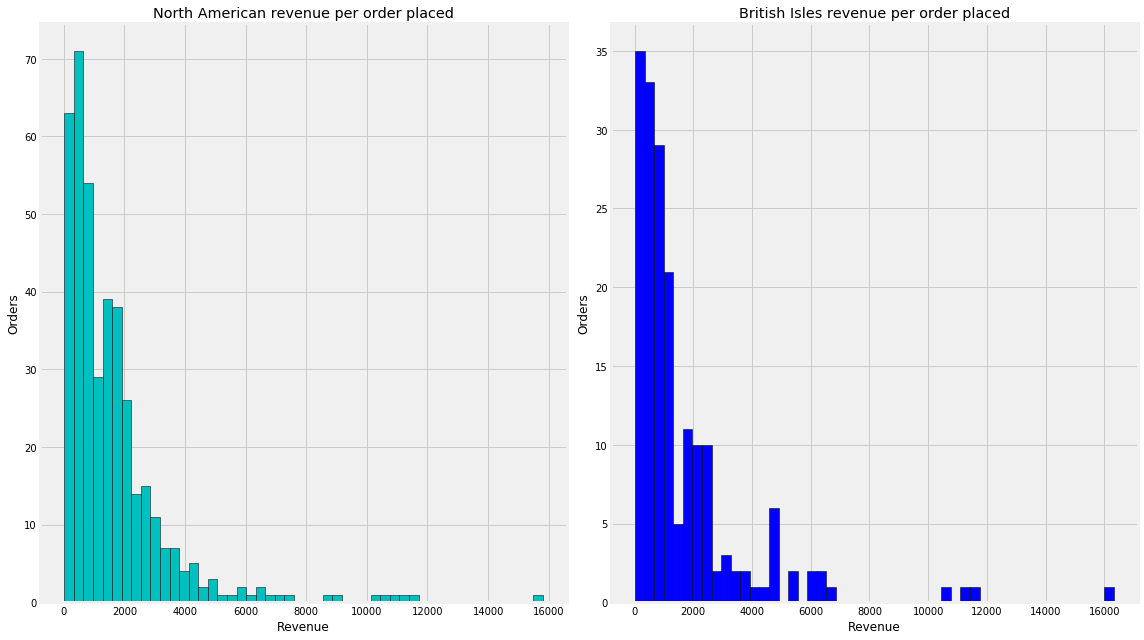

In [28]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.hist(NA_sales['tot_revenue'], color='c', edgecolor='k', bins=50)
ax2.hist(BI_sales['tot_revenue'], color = 'b', edgecolor='k', bins=50)
ax1.set_title("North American revenue per order placed")
ax2.set_title("British Isles revenue per order placed")
ax1.set_xlabel("Revenue")
ax1.set_ylabel("Orders")
ax2.set_xlabel("Revenue")
ax2.set_ylabel("Orders")
plt.tight_layout()
plt.show();

Again, let's declare our hypotheses and significance level prior to testing:

**H<sub>0</sub>: The average revenue generated is the same regardless of sales representative office region** <br>
**H<sub>A</sub>: The average revenue generated is higher for orders placed in the British Isles sales region than the North American sales region.** <br>
**$\alpha$: 0.05** <br>
<br>
We will again use a one-tailed, two-sample t-test based on our experimental design.

In [29]:
t, p = stats.ttest_ind(BI_sales['tot_revenue'], NA_sales['tot_revenue'])
print('T-statistic: {}, Two-tailed p-value: {}'.format(t,p))# this is 2-tailed by default
print('One tailed p-value: {}'.format(p/2))  #to give us our 1-tailed p-value

T-statistic: 0.1294527068470579, Two-tailed p-value: 0.8970438644331271
One tailed p-value: 0.44852193221656356


## Q2 results:

Our p-value is well above 0.05, so we fail to reject the null hypothesis and conclude that there is no significant difference in revenue generated based on a sales representative's office location.  

The rationale behind this test was to determine if we should consider locating more (or perhaps all) of our workforce in the British Isles due to the closer proximity to our majority European customer base.  Based on the findings, there is no justification to consider such a move at this time.  However, I'd recommend that we conduct some further testing in the future to approach the broader idea (moving the base of operations in Europe) from other angles.

# Q3:  Does our average profit margin per order placed vary significantly depending on which region supplies the products?

**H<sub>0</sub>: There is no difference in the average profit margin per order placed, regardless of the region from which the product was supplied** <br>
**H<sub>A</sub>: There is a difference in the average profit margin per order placed, depending on the region from which the product was supplied** <br>
**$\alpha$: 0.05**

Here we are joining OrderDetail, Product, and Supplier Tables to take a closer look at our profitability levels by supplier. <br>

It's important to note that we have two different Unit Prices - from the OrderDetail table I've encoded UnitPrice as "WholeSalePrice" and from the ProductTable I've encoded UnitPrice as "Retail Price" to differentiate the two.

In [30]:
q3 = '''SELECT od.OrderId, od.UnitPrice as WholesalePrice, od.Quantity, p.CategoryId, p.ProductName, p.UnitPrice as RetailPrice, s.CompanyName, s.Region FROM OrderDetail od
        LEFT JOIN Product p ON od.ProductId = p.Id
        LEFT JOIN Supplier s ON p.SupplierId = s.Id
        ORDER BY s.Region'''
q3_df = pd.read_sql_query(q3, engine)

2019-03-26 20:56:40,116 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, od.UnitPrice as WholesalePrice, od.Quantity, p.CategoryId, p.ProductName, p.UnitPrice as RetailPrice, s.CompanyName, s.Region FROM OrderDetail od
        LEFT JOIN Product p ON od.ProductId = p.Id
        LEFT JOIN Supplier s ON p.SupplierId = s.Id
        ORDER BY s.Region
2019-03-26 20:56:40,120 INFO sqlalchemy.engine.base.Engine ()


In [31]:
q3_df.head()

,OrderId,WholesalePrice,Quantity,CategoryId,ProductName,RetailPrice,CompanyName,Region
0,10252,64.8,40,3,Sir Rodney's Marmalade,81.0,"Specialty Biscuits, Ltd.",British Isles
1,10255,15.2,20,1,Chang,19.0,Exotic Liquids,British Isles
2,10258,15.2,50,1,Chang,19.0,Exotic Liquids,British Isles
3,10259,8.0,10,3,Sir Rodney's Scones,10.0,"Specialty Biscuits, Ltd.",British Isles
4,10261,8.0,20,3,Sir Rodney's Scones,10.0,"Specialty Biscuits, Ltd.",British Isles


In [32]:
q3_df['profit_per_order'] = (q3_df['RetailPrice'] - q3_df['WholesalePrice']) * q3_df['Quantity']

In [33]:
q3_df.groupby('Region')['CompanyName'].describe()

,count,unique,top,freq
Region,,,,
British Isles,220,2,"Specialty Biscuits, Ltd.",126
Eastern Asia,119,2,Mayumi's,68
NSW,98,1,"G'day, Mate",98
North America,418,6,New England Seafood Cannery,88
Northern Europe,153,4,Svensk Sjöföda AB,51
Scandinavia,175,2,Norske Meierier,105
South America,51,1,Refrescos Americanas LTDA,51
South-East Asia,82,1,Leka Trading,82
Southern Europe,229,3,Formaggi Fortini s.r.l.,104


The above gives us a sense of how many suppliers we have in each region and how much of our inventory comes from each.

In [34]:
print(q3_df['ProductName'].nunique())
print(q3_df['CompanyName'].nunique())

77
29


In [35]:
q3_df.groupby('Region')['profit_per_order'].mean().sort_values(ascending=False)

Region
Western Europe     86.561790
Victoria           51.785583
NSW                45.948980
South-East Asia    38.922561
Southern Europe    37.510917
North America      35.441866
Scandinavia        31.386000
British Isles      25.947727
Eastern Asia       21.894958
Northern Europe    16.919935
South America       5.488235
Name: profit_per_order, dtype: float64

This gives us an initial sense of how profitable each supplier region is.  **What is happening in South America?!**

In [36]:
q3_df[q3_df['Region'] == 'South America']['profit_per_order'].value_counts()

0.0     36
9.0      3
13.5     3
25.2     2
10.8     2
22.5     2
5.4      1
72.0     1
18.0     1
Name: profit_per_order, dtype: int64

Most of our products from South America appear to be sold AT COST.

In [37]:
q3_df[(q3_df.Region == 'South America') & (q3_df.profit_per_order == 0.0)]['ProductName'].unique()

array(['Guaraná Fantástica'], dtype=object)

OK, this is a minor relief.  Going back to our Discontinued table from our initial EDA, we see that this product is in fact discontinued.  Northwind has already come its senses and decided not to sell this product since they make literally no profit on it. The other South American orders are also fairly unprofitable...let's look at those too: <br>

In [38]:
q3_df[(q3_df.Region == 'South America')& (q3_df.profit_per_order != 0.0)]['ProductName'].unique()

array(['Guaraná Fantástica'], dtype=object)

Interesting...it appears that at some point that our supplier raised the price for this product, at which point we sold it at cost for a while and then stopped selling it altogether.  
At any rate, with this discovery, perhaps I should add a "where" clause to my select statement to filter out the discontinued products (since the company is presumably no longer interested in analyzing those).  

In [39]:
q3b = '''SELECT od.OrderId, od.UnitPrice as WholesalePrice, od.Quantity, p.CategoryId, p.ProductName, p.UnitPrice as RetailPrice, s.CompanyName, s.Region FROM OrderDetail od
        LEFT JOIN Product p ON od.ProductId = p.Id
        LEFT JOIN Supplier s ON p.SupplierId = s.Id
        WHERE p.Discontinued = 0
        ORDER BY s.Region'''
q3b_df = pd.read_sql_query(q3b, engine)

2019-03-26 20:56:40,340 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, od.UnitPrice as WholesalePrice, od.Quantity, p.CategoryId, p.ProductName, p.UnitPrice as RetailPrice, s.CompanyName, s.Region FROM OrderDetail od
        LEFT JOIN Product p ON od.ProductId = p.Id
        LEFT JOIN Supplier s ON p.SupplierId = s.Id
        WHERE p.Discontinued = 0
        ORDER BY s.Region
2019-03-26 20:56:40,341 INFO sqlalchemy.engine.base.Engine ()


In [40]:
q3b_df['profit_per_order'] = (q3b_df['RetailPrice'] - q3b_df['WholesalePrice']) * q3b_df['Quantity']

In [41]:
q3b_df.Region.value_counts()

North America      408
Western Europe     382
Southern Europe    229
British Isles      220
Scandinavia        175
Northern Europe    153
Victoria           126
Eastern Asia       114
NSW                 68
South-East Asia     52
Name: Region, dtype: int64

As we can see now, South America is out of the picture as they only supplied the one discontinued product.

In [42]:
q3b_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 9 columns):
OrderId             1927 non-null int64
WholesalePrice      1927 non-null float64
Quantity            1927 non-null int64
CategoryId          1927 non-null int64
ProductName         1927 non-null object
RetailPrice         1927 non-null float64
CompanyName         1927 non-null object
Region              1927 non-null object
profit_per_order    1927 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 135.6+ KB


In [43]:
list(q3b_df['Region'].unique())

['British Isles',
 'Eastern Asia',
 'NSW',
 'North America',
 'Northern Europe',
 'Scandinavia',
 'South-East Asia',
 'Southern Europe',
 'Victoria',
 'Western Europe']

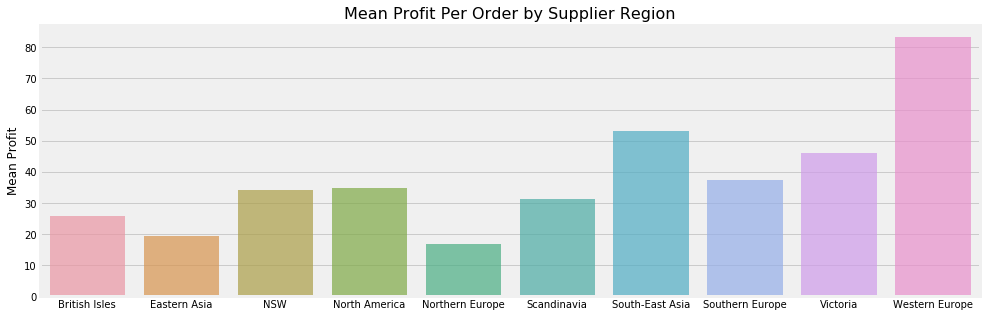

In [44]:
y = np.array(q3b_df.groupby('Region')['profit_per_order'].mean())#.plot(kind='bar')
x = list(q3b_df['Region'].unique())
plt.figure(figsize=(15,5))
plt.title("Mean Profit Per Order by Supplier Region", fontsize =16)
sns.barplot(x,y, alpha = 0.7)
plt.ylabel('Mean Profit', fontsize=12)
plt.show();


This visualization alone lends some support to my idea posed earlier regarding Western Europe as a potential base of operations ...but we'll need to do some hypothesis testing to determine whether there's a statistically significant difference amongst regional suppliers.

Again, to start, let's look at ANOVA testing results since we have more than 2 samples to compare.

In [45]:
formula = 'profit_per_order ~ C(Region)'
lm = ols(formula, q3b_df).fit()
table = sm.stats.anova_lm(lm, typ=1) #1 way anova because we only have 1 ind var (profit_per_order)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Region),9.0,9.147662e+05,101640.684966,4.581441,0.000005
Residual,1917.0,4.252924e+07,22185.309271,NaN,NaN


We have a very low p-value from Anova testing...let's look at Tukey HSD and how they compare to one another.

In [46]:
mc = MultiComparison(q3b_df['profit_per_order'], q3b_df['Region'])
mc_results = mc.tukeyhsd()
print(mc_results)

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper   reject
-----------------------------------------------------------------
 British Isles    Eastern Asia   -6.496  -60.9405 47.9485  False 
 British Isles        NSW        8.3405  -57.1193 73.8004  False 
 British Isles   North America   8.9874  -30.4749 48.4498  False 
 British Isles  Northern Europe -9.0278  -58.6918 40.6362  False 
 British Isles    Scandinavia    5.4383  -42.3491 53.2256  False 
 British Isles  South-East Asia 27.2455  -45.5016 99.9927  False 
 British Isles  Southern Europe 11.5632  -32.9756  56.102  False 
 British Isles      Victoria    19.9352  -32.7739 72.6444  False 
 British Isles   Western Europe 57.2035  17.2735  97.1336   True 
  Eastern Asia        NSW       14.8365  -57.4527 87.1257  False 
  Eastern Asia   North America  15.4834  -34.4967 65.4635  False 
  Eastern Asia  Northern Europe -2.5318  -60.9035 55.8398  False 
  Eastern 

This is not super informative on its face...most of the significant results come from comparing less profitable regions to Western Europe, which is clearly our top performer.  Perhaps instead we should be doing a 1-sample t-test for each region and comparing to the population mean.  Let's create a function that can do the dirty work, then a for loop to test each region.

Let's reformulate our hypotheses slightly since we're really only interested in supply regions that operate at a lower profit margin than the mean:

**H<sub>0</sub>: There is no difference in the average profit margin per order placed, regardless of the region from which the product was supplied.** <br>
**H<sub>A</sub>: One or more supply regions generate an average profit margin per order placed below the mean average profit margin per order.** <br>
**$\alpha$: 0.05**

In [47]:
def profit_1_samp(sample, mu, alpha):
    x_bar = round(sample.mean(),2)
    sigma = round(np.std(sample, ddof=1), 2)
    n = len(sample)
    df = n - 1
    diff = round((x_bar - mu),2)
    d = np.round(((diff) / sigma),2)
    crit_t = stats.t.ppf(1-alpha, df)
    print('The sample contains', n, 'observations')
    print('The difference between sample mean and population mean is', diff)
    if abs(d) < 0.2:
        print("We observe a small effect size (Cohen's d):", d)
    elif 0.2 < abs(d) < 0.5:
        print("We observe a medium effect size (Cohen's d):", d)
    else:
        print("We observe a large effect size (Cohen's d):", d)
    print('----------------------------------------------------------------------------------')
       

    results = stats.ttest_1samp(a= sample, popmean= mu)
    t = round(results[0],2)
    p = round((results[1]/2), 4) #one-tailed p-value
    print ("The t-value for the sample is", abs(t), "and the p-value is", p)
    
    if abs(t) > crit_t and p < alpha:
        print('We reject the null hypothesis and find the results to be statistically significant, with a p-value of', p, 'which is <', alpha)
        
    else:
        print('We fail to reject the null hypothesis with a p-value of', p, ',which is >', alpha)



In [48]:
profit_regions = list(q3b_df['Region'].unique())
profit_regions

['British Isles',
 'Eastern Asia',
 'NSW',
 'North America',
 'Northern Europe',
 'Scandinavia',
 'South-East Asia',
 'Southern Europe',
 'Victoria',
 'Western Europe']

We have already demonstrated that Western Europe is vastly superior as a supply region in terms of profitability, so we can remove it from our list before testing.

In [49]:
profit_regions.pop()

'Western Europe'

In [50]:
for region in profit_regions:
    alpha = 0.05
    mu = q3b_df['profit_per_order'].mean()
    sample = q3b_df[q3b_df['Region'] == region]['profit_per_order']
    print('Results for', region,':\n')
    profit_1_samp(sample, mu, alpha)   
    print('\n')



Results for British Isles :

The sample contains 220 observations
The difference between sample mean and population mean is -16.34
We observe a medium effect size (Cohen's d): -0.24
----------------------------------------------------------------------------------
The t-value for the sample is 3.52 and the p-value is 0.0003
We reject the null hypothesis and find the results to be statistically significant, with a p-value of 0.0003 which is < 0.05


Results for Eastern Asia :

The sample contains 114 observations
The difference between sample mean and population mean is -22.84
We observe a large effect size (Cohen's d): -0.55
----------------------------------------------------------------------------------
The t-value for the sample is 5.92 and the p-value is 0.0
We reject the null hypothesis and find the results to be statistically significant, with a p-value of 0.0 which is < 0.05


Results for NSW :

The sample contains 68 observations
The difference between sample mean and populati

## Q3 results:

Very interesting...the above suggests that we can *reject the null hypothesis and that we find statistically significant differences for the following supplier regions:*

- **British Isles**
- **Eastern Asia**
- **Nothern Europe**
- **Scandinavia** (note for this one that the effect size is small, so we may want to consider further testing before reaching any conclusions)

*Next steps?*  

1. Well, a major shake-up could be in store for our supply chain.  We should explore whether we can replace those same products using suppliers from our more profitable regions.  If not, perhaps we should discontinue some of those products so that we can tighten up our supply chain and focus on the products that come from the more profitable regions. 
<br>

2. Further testing could also incorporate the freight costs, as those may further weigh down profitability (depending on who the responsible party is for the freight - customer or Northwind, or some combination of both depending on Service Level Agreements).  Considering that in some cases we are shipping these across the world, it would be an important consideration if Northwind is responsible for any portion of it.  I suspect that having a warehouse in Western Europe and using Western European shippers would drastically improve on our current performance.

# Q4: When a customer places an order, are the higher-priced products ordered in higher quantities than the lower-priced products?


The reason I thought to ask this came from stepping back and thinking about the unique value that Northwind Traders offers in the marketplace, it's as a purveyor of niche items, regional delicacies, etc. that can't be easily obtained by its customer base.  I expect demand to be relatively price-inelastic as a result...people want these particular products and they're willing to pay to have them shipped across the world, so it seems like they'd probably gravitate towards the high-end products and away from more common "novelty" items (going back to the discontinued products, a quick glance at that list confirms this rationale).  

**H<sub>0</sub>: Unit price does not have an effect on quantity ordered (on a per order basis)** <br>
**H<sub>A</sub>: Higher unit prices result in higher quantities ordered (on a per order basis)** <br>
**$\alpha$: 0.05** <br>

In [51]:
q4 = '''SELECT od.OrderId, p.ProductName, p.UnitPrice, SUM(od.Quantity) as tot_quant, c.CategoryName FROM OrderDetail od
        LEFT JOIN Product p ON p.Id = od.ProductId
        LEFT JOIN Category c ON c.ID = p.CategoryId
        GROUP BY od.OrderId'''
q4_df = pd.read_sql_query(q4, engine)

2019-03-26 20:56:40,781 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, p.ProductName, p.UnitPrice, SUM(od.Quantity) as tot_quant, c.CategoryName FROM OrderDetail od
        LEFT JOIN Product p ON p.Id = od.ProductId
        LEFT JOIN Category c ON c.ID = p.CategoryId
        GROUP BY od.OrderId
2019-03-26 20:56:40,782 INFO sqlalchemy.engine.base.Engine ()


In [52]:
q4_df.head()

,OrderId,ProductName,UnitPrice,tot_quant,CategoryName
0,10248,Mozzarella di Giovanni,34.80,27,Dairy Products
1,10249,Manjimup Dried Apples,53.00,49,Produce
2,10250,Louisiana Fiery Hot Pepper Sauce,21.05,60,Condiments
3,10251,Louisiana Fiery Hot Pepper Sauce,21.05,41,Condiments
4,10252,Camembert Pierrot,34.00,105,Dairy Products


In [53]:
q4_df.shape

(830, 5)

In [54]:
q4_df.UnitPrice.median()

19.225

I decided to subset the data using the median UnitPrice to ensure balanced samples.  We could certainly do further testing in the future using different parameters, as the sample sizes don't have to be equal.

In [55]:
expensive = q4_df[q4_df['UnitPrice'] > 19.225]
cheap = q4_df[q4_df['UnitPrice'] < 19.225]

In [56]:
print(expensive.shape)
print(cheap.shape)

(415, 5)
(415, 5)


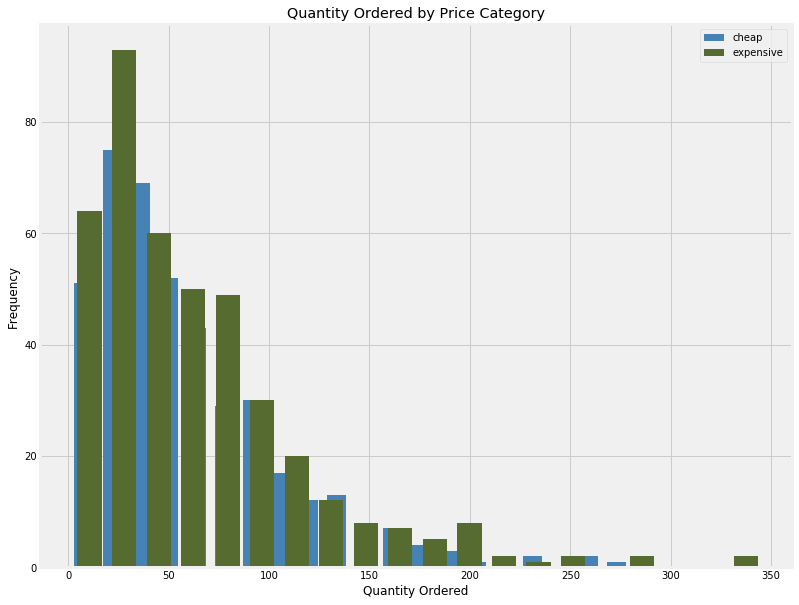

In [57]:
plt.figure(figsize=(12,10))
plt.hist(cheap['tot_quant'], bins=20, rwidth=0.7, color ='steelblue', label ='cheap')
plt.hist(expensive['tot_quant'], bins=20, rwidth=0.7, color ='darkolivegreen', label = 'expensive')
plt.title('Quantity Ordered by Price Category')
plt.xlabel('Quantity Ordered')
plt.ylabel('Frequency')
plt.legend()
plt.show();

In [58]:
t, p = stats.ttest_ind(expensive['tot_quant'], cheap['tot_quant'])
print('T-statistic: {}, Two-tailed p-value: {}'.format(t,p))# this is 2-tailed by default
print('One tailed p-value: {}'.format(p/2))  #to give us our 1-tailed p-value

T-statistic: 1.928546825918386, Two-tailed p-value: 0.054128722342161796
One tailed p-value: 0.027064361171080898


## Q4 results:

With this p-value, we can ***reject the null hypothesis and conclude that there IS a statistically significant difference between "expensive" vs. "cheap" products in terms of quantity ordered (on a per order basis).***  

My advice to Northwind is to focus exclusively on the higher-priced products (i.e. those with retail prices above $19.23).  Combined with the earlier advice to move away from some of our less profitable suppliers, we may be able to pare down the product line significantly with this approach.  

We should also conduct some further testing to determine if the median price point is actually the ideal threshold.

# General Conclusions and Recommendations:

- Offer discounts to drive sales and increase revenue, but offering ANY discount is sufficient.  To maximize profitability, offer discounts at the lowest standard level of 5% only.

- Sales representatives can remain in their current office locations, half in North America and half in the British Isles.  

- Consider a tighter focus on where we source from and what we sell.  
    - We are deriving considerably lower profit margins from certain suppliers/regions.
    - Customers are buying high-end, high-priced items in bulk more often.

- While I don't have a specific hypothesis test to justify it immediately, I think we should continue to investigate the merits of relocating our base of operations to Western Europe.  The majority of our customers are close to that area, we make the most profit when sourcing products from Western European suppliers...in general it seems like this is where the opportunities can be maximized for our particular market.

As it stands, our value proposition is being able to offer products in the marketplace that aren't easily obtained otherwise.  Consumer demand is not driven by price for these items; they'll pay whatever it costs.  As we consider expanding into new product offerings, this insight should be a key consideration.  Likewise, we should set up a meeting with marketing and discuss a potential rebrand.  This is outside of my purview as a data scientist, but I think changing the name to something that will attract a "big-spender" demographic that is more likely to seek out expensive and obscure food items might be a worthwhile discussion.  Do we want to be a company that sells quirky regional food products?  Or one that offers "luxurious" products fit for royalty but accessible to anyone willing to pay for high quality goods?  A few suggestions: 
>- Northwind Fine Foods Inc. 
>- Northwind Gourmet Retailers
>- Northwind Epicurean Traders 
>- Northwind Delicacies & Co.

In my humble opinion, any of these would be significant improvement on the vanilla "Northwind Traders."  It would also give our company a more distinct identity and direction, which would undoubtedly help our sales and marketing teams pitch our company.